## Введение

По проекту, нужно провести анализ и подготовить план действий по удержанию клиентов для фитнес-центра.

Данные предоставлены Яндекс.Практикумом для обучения.

## Загрузим данные

### используемые библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans
import itertools

### загружаемые данные

In [2]:
# запишем варианты загрузки
try:
    df = pd.read_csv('/datasets/gym_churn.csv')
except:
    df = pd.read_csv('C:/Users/user/Desktop/tasks/project_9/gym_churn.csv')

### используемые функции

#### start_view: первоначальный осмотр датафрейма

In [3]:
# соберём функцию первоначального осмотра датафрейма
def start_view(dataframe):
    index = dataframe[dataframe.duplicated(keep = False)].sort_values(by = list(dataframe.columns)) # keep = False выведет все совпадения
    print("Количество дубликатов:", index)
    dataframe.info()
    display(dataframe.describe())
    display(dataframe.head())

In [4]:
start_view(df)

Количество дубликатов: Empty DataFrame
Columns: [gender, Near_Location, Partner, Promo_friends, Phone, Contract_period, Group_visits, Age, Avg_additional_charges_total, Month_to_end_contract, Lifetime, Avg_class_frequency_total, Avg_class_frequency_current_month, Churn]
Index: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                            

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Мы можем сказать, что:
1. датасет не содержит пропусков (кол-во данных во всех столбцах одинаковое),
2. данные даны в правильных числовых форматах,
3. есть небольшое преобладание одного пола над другим (среднее арифметическое 0,51),
4. в среднем, посетители фитнес-центра живут рядом,
5. почти половина от всех посетителей приходят со статусом "сотрудник компании-партнёра клуба",
6. около 30% пришло по приглашению от уже действующего посетителя,
7. почти 90% от всех зарегистрированных в базе клуба оставляли контактный телефон,
8. в среднем, пользователи оплачивают 4,7 месяцев абонемента, при том что половина из посетителей оплачивали только 1 месяц абонемента,
9. примерно 41% посетителей посещают групповые занятия,
10. средний возраст посетителя - 29 лет, минимальный - 18 лет, максимальный - 41 год,
11. за дополнительные опции посетитель платит в среднем 146,9 тысяч денег, при том что диапазон колеблется от 148 единиц денег до 552,59 тысяч денег; примерно половина из посетителей тратит в месяц до 136,22 тыс денег на дополнительные опции,
12. в среднем, посетители ходят на фитнес около 3,7 месяцев: половина из всех до 3 месяцев, три четверти - 5 месяцев. Рекорд зала - 31 месяц,
13. в среднем, пользователи посещают зал чуть меньше 2х раз в неделю, максимум - чуть более 6 раз в неделю за месяц,
14. среднее число посещений зала в неделю за предыдущий месяц немного ниже значений текущего месяца, но в целом идёт на том же уровне,
15. статус "Churn" (перестал посещать) присвоен примерно 26% зарегистрированных посетителей.

## Проведем исследовательский анализ данных (EDA)

### посмотрим на датасет подробнее

In [5]:
# сгруппируем данные по маркеру "отвалился" (перестал посещать)
df_group = df.groupby(['Churn']).mean()
df_group

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


После группировки можно сравнить в среднем продолжающих посещать и переставших:
1. продолжающие посещать живут рядом чаще, чем те, кто перестал посещать (87% против 76%),
2. продолжающие посещать чаще пришли по партнёрской программе и чаще имеют промокоды от друзей,
3. контактный телефон оставляют практически одинаково охотно,
4. продолжающие посещать чаще оплачивают длительный абонемент (в среднем на 5,7 месяцев, против 1,7 месяцев абонемента в среднем у отвалившихся),
5. продолжающие посещать чаще посещают групповые занятия (46% против 26% отвалившихся),
6. продолжающие посещать посетители в среднем старше - почти 30 лет, тогда как переставшие посещать посетители имеют средний возраст почти 27 лет,
7. продолжающие посещать посетители больше тратят на доп.функции: 158,4 тыс денег против 115 тыс денег у отвалившихся,
8. у продолжающих посещать в среднем ещё 5,2 оплаченных месяца в абонементе, тогда как у отвалившихся - 1,6 месяца,
9. продолжающие посещать имеют в среднем 4,7 месяца активных посещений, тогда как отвалившиеся - 0,99 месяца,
10. продолжающие посещать приходят на фитнес в среднем 2 раза в неделю, тогда как отвалившиеся - 1,47 раза,
11. продолжающие посещать приходили в предыдущий месяц почти такое же кол-во раз, тогда как отвалившиеся - 1,04 раза в среднем.

### диаграммы

/tmp/ipykernel_87/3819258449.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 3, 3)


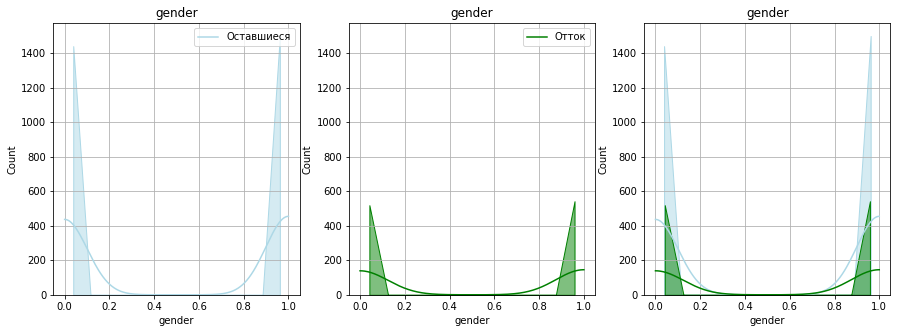

/tmp/ipykernel_87/3819258449.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 3, 3)


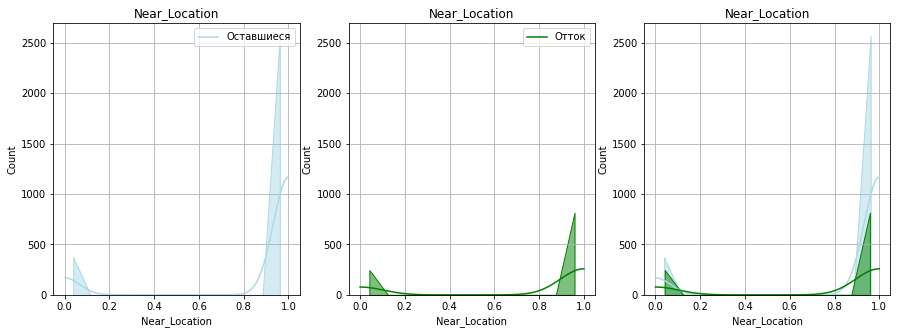

/tmp/ipykernel_87/3819258449.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 3, 3)


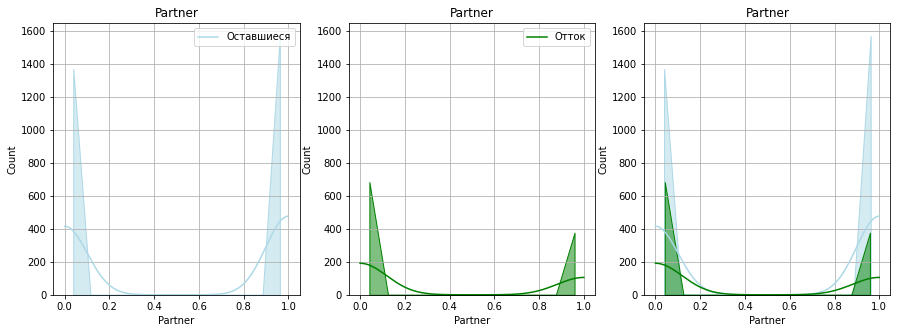

/tmp/ipykernel_87/3819258449.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 3, 3)


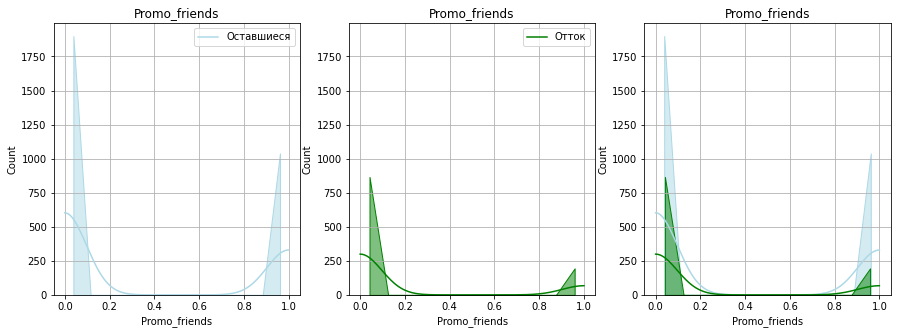

/tmp/ipykernel_87/3819258449.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 3, 3)


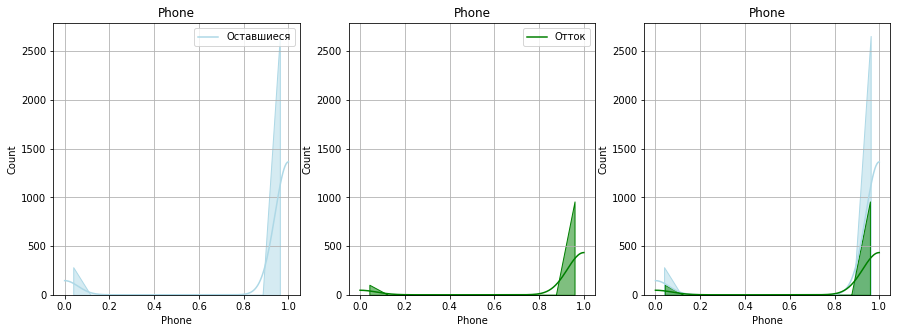

/tmp/ipykernel_87/3819258449.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 3, 3)


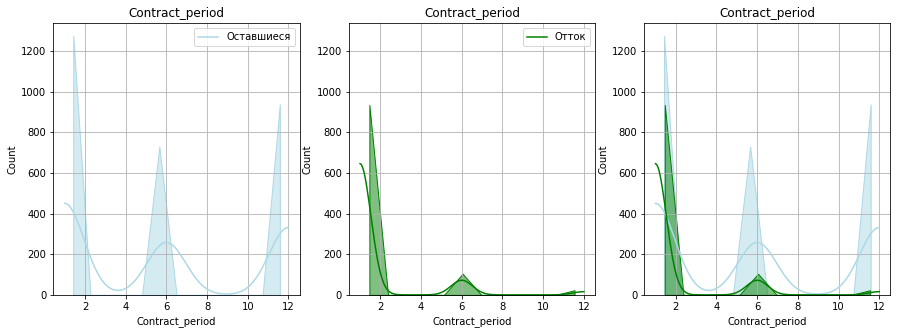

/tmp/ipykernel_87/3819258449.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 3, 3)


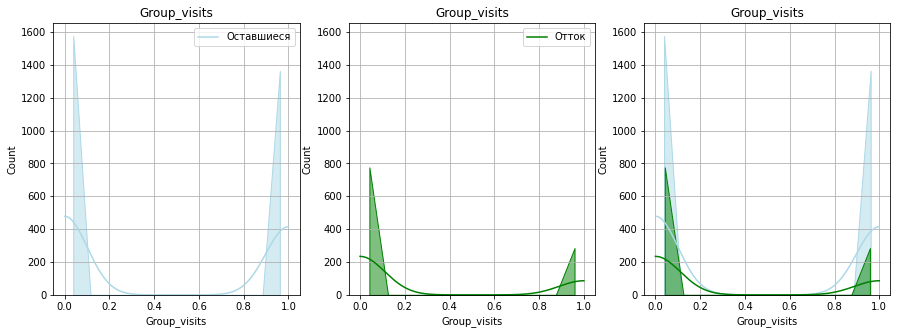

/tmp/ipykernel_87/3819258449.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 3, 3)


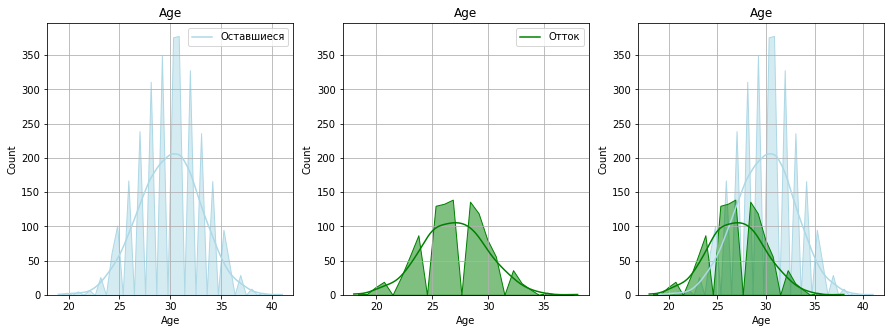

/tmp/ipykernel_87/3819258449.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 3, 3)


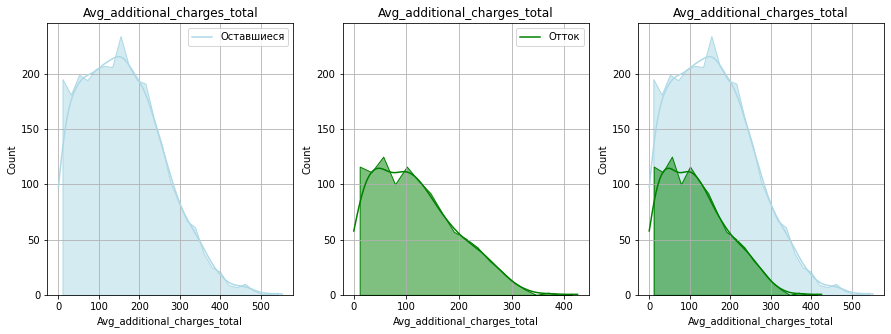

/tmp/ipykernel_87/3819258449.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 3, 3)


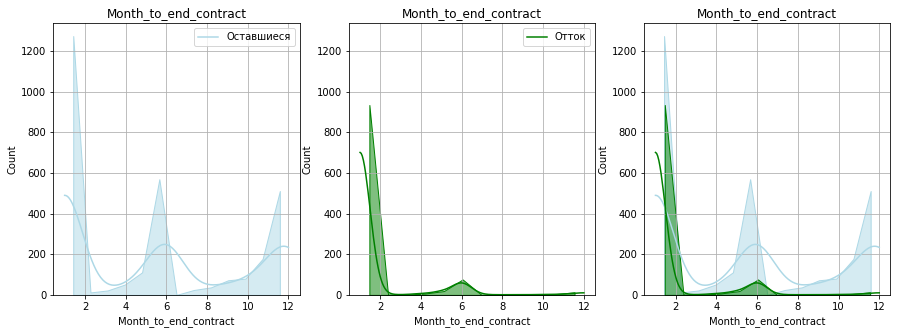

/tmp/ipykernel_87/3819258449.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 3, 3)


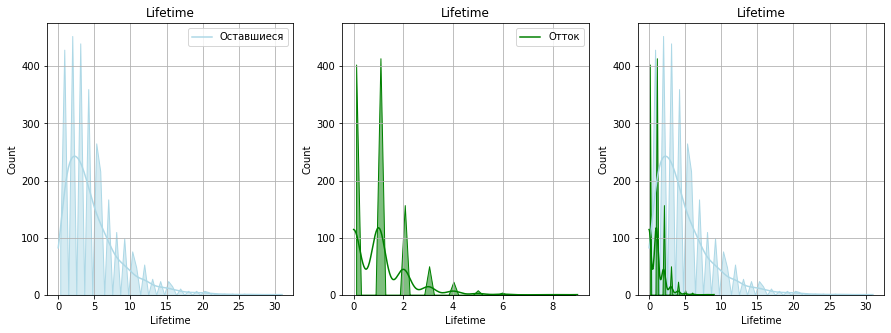

/tmp/ipykernel_87/3819258449.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 3, 3)


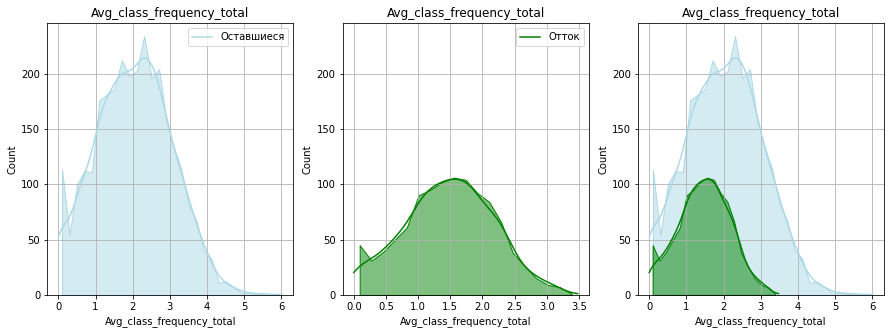

/tmp/ipykernel_87/3819258449.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 3, 3)


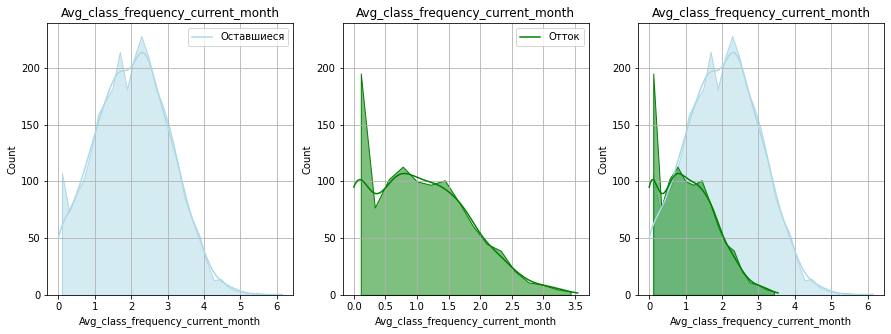

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/tmp/ipykernel_87/3819258449.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 3, 3)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skippi

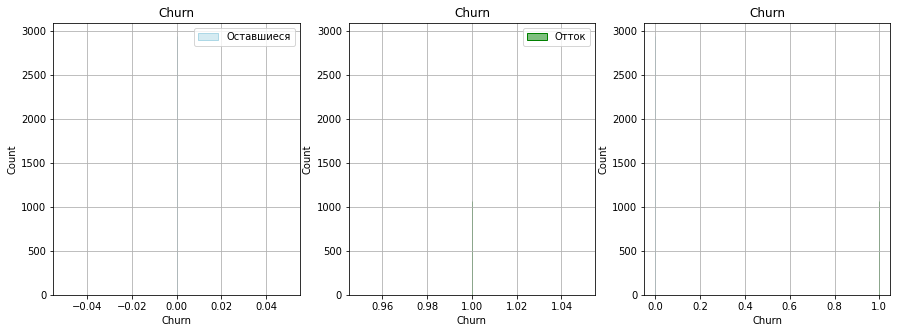

In [6]:
stay = df[df['Churn']==0]
not_stay = df[df['Churn']==1]
data = df.columns
for i in data:
    plt.figure(figsize=(15,5))
    main_fig = plt.subplot(1, 3, 3)
    plt.subplot(1, 3, 1, sharey=main_fig)
    plt.grid(visible=True)
    plt.title(i)
    sns.histplot(data=stay[i], element="poly", color='lightblue', kde=True)
    plt.legend(['Оставшиеся'])
    plt.subplot(1, 3, 2, sharey=main_fig)
    plt.title(i)
    plt.grid(visible=True)
    sns.histplot(data=not_stay[i], element="poly", color='green', kde=True)
    plt.legend(['Отток'])
    plt.subplot(1, 3, 3)
    plt.title(i)
    plt.grid(visible=True)
    sns.histplot(data=stay[i], element="poly", color='lightblue', kde=True)
    sns.histplot(data=not_stay[i], element="poly", color='green', kde=True)
    plt.show()

### матрица коррелляций

In [7]:
# построим матрицу корреляций
cm = df.corr()

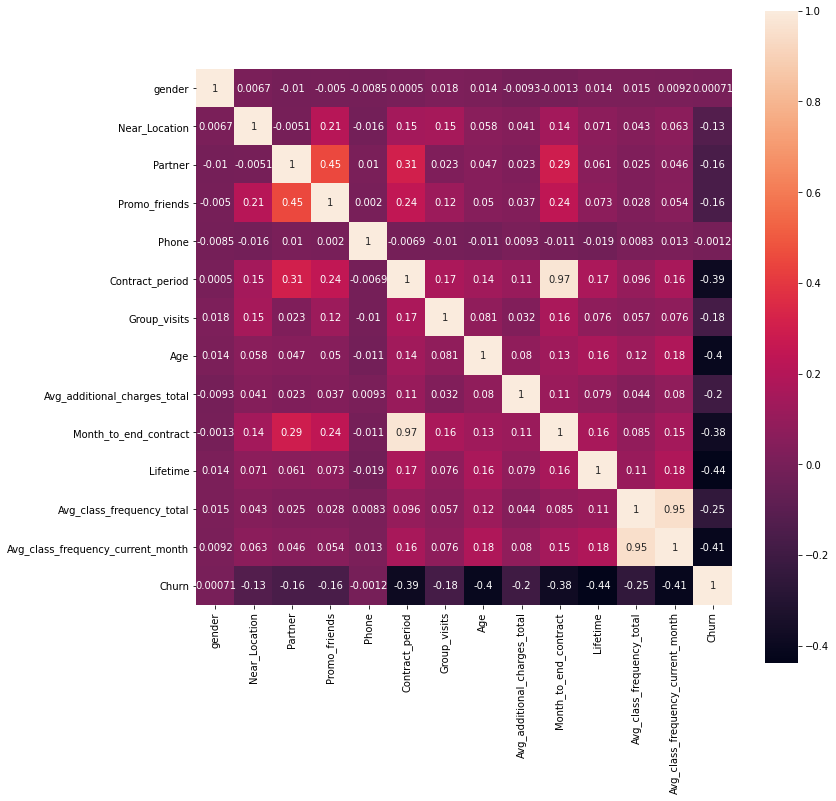

In [8]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(cm, annot=True, square=True)
ax.set_ylim(14,0)  # корректировка "рваных" полей heatmap в последней версии библиотеки
plt.show()

Судя по диаграмме корелляций, факт оттока обратно корреллирует с параметрами:
1. продолжительности абонемента (чем меньше оплачено - тем больше шансов, что отвалится),
2. возрастом (чем младше - тем больше шансов что отвалится),
3. оставшимся кол-вом оплаченных месяцев (чем меньше осталось - тем больше шансов, что отвалится),
4. кол-вом посещений в предыдущем месяце (чем меньше посещений в неделю в среднем в предыдущем месяце - тем больше шансов, что отвалится).

При этом, есть положительные коррелляции:
1. чем больше раз в неделю посещал в предыдущем месяце - тем больше шансов, что придёт и в этом,
2. если человек пришёл с промокодом от друга - то повышается шанс, что он будет из компании-партнёра и жить рядом.
3. человек из компании-партнёра чуть чаще остальных покупает длительный абонемент (и, соответственно, имеет больше месяцев предоплаченного контракта).

## Построим модель прогнозирования оттока клиентов

### подготовим данные для построения моделей

In [9]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('Churn', axis=1) # матрица признаков
y = df['Churn'] # целевая переменная

# разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) #ваш код здесь

# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(
    X_train
)  # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

### список используемых моделей

In [10]:
# зададим список моделей, которые будем проверять
models = [
    LogisticRegression(solver='liblinear', random_state=0),    
    RandomForestClassifier(n_estimators = 100, random_state=0)    
]

### вспомогательные функции mape, make_prediction

In [11]:
# функция, которая вычисляет MAPE
def mape(y_true, y_pred):
    y_error = y_true - y_pred
    y_error_abs = [abs(i) for i in y_error]
    perc_error_abs = y_error_abs / y_true
    mape = perc_error_abs.sum() / len(y_true)
    return mape


# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'MAE:{:.2f} MSE:{:.2f} MAPE:{:.2f} R2:{:.2f} '.format(
            mean_absolute_error(y_test, y_pred),
            mean_squared_error(y_test, y_pred),
            mape(y_test, y_pred),
            r2_score(y_test, y_pred),
        )
    )

### модели прогноза оттока клиентов

In [12]:
# цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(i, X_train, y_train, X_test, y_test)
print('---')
# цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(
        m=i,
        X_train=X_train_st,
        y_train=y_train,
        X_test=X_test_st,
        y_test=y_test,
    )


LogisticRegression(random_state=0, solver='liblinear')
MAE:0.07 MSE:0.07 MAPE:inf R2:0.60 
RandomForestClassifier(random_state=0)
MAE:0.08 MSE:0.08 MAPE:inf R2:0.55 
---
LogisticRegression(random_state=0, solver='liblinear')
MAE:0.08 MSE:0.08 MAPE:inf R2:0.58 
RandomForestClassifier(random_state=0)
MAE:0.09 MSE:0.09 MAPE:inf R2:0.54 


Показатели у модели случайного леса в целом лучше, выберем её.

### RandomForest

In [13]:
# обучим модель случайного леса отдельно
final_model = RandomForestClassifier(n_estimators = 100, random_state=0)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

# создадим датафрейм с именами признаков и их важностью и выведем его по убыванию важности
importances = final_model.feature_importances_
p = []
for i in X_test.columns:
    p.append(i)

d = {'Признак': p, 'Важность': importances}
df_importances = pd.DataFrame(data=d)

print (df_importances.sort_values(by='Важность', ascending=False))

                              Признак  Важность
10                           Lifetime  0.276499
12  Avg_class_frequency_current_month  0.180170
11          Avg_class_frequency_total  0.129883
7                                 Age  0.119129
8        Avg_additional_charges_total  0.091473
9               Month_to_end_contract  0.068855
5                     Contract_period  0.065964
6                        Group_visits  0.015652
0                              gender  0.012425
2                             Partner  0.012285
3                       Promo_friends  0.012053
1                       Near_Location  0.009421
4                               Phone  0.006192


В итоге, наиболее важными признаками можно считать длительность посещения зала, среднее кол-во посещений в неделю в предыдущем месяце, среднее кол-во посещений в текущем месяце, возраст и суммарные траты на доп.опции.

## Сделаем кластеризацию клиентов

### стандартизируем данные

In [14]:
# стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(X)

### linkage

In [15]:
linked = linkage(x_sc, method = 'ward') 

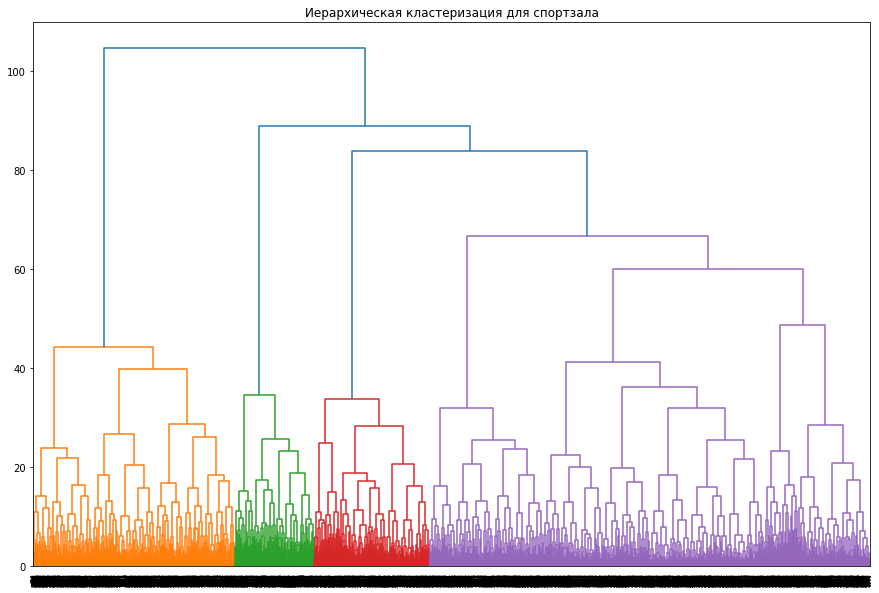

In [16]:
# выведем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация для спортзала')
plt.show() 

Видим группы 4 группы данных, которые можно разбить на 5 блоков.

### KMeans

In [17]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(x_sc)

In [18]:
# оценим качество разделения на кластеры
silhouette_score(x_sc, labels)

0.14140953623023353

Чем ближе к единице - тем лучше. Другие варианты числа кластеров дают результат ещё ниже, поэтому оставим это количество.

In [44]:
# определим функцию отрисовки графиков попарных признаков для небулевых кластеров
def show_clusters_on_plot_non_boolean(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    plt.grid(visible=True)
    sns.scatterplot(
        x=df[x_name], y=df[y_name], hue=df[cluster_name], palette='Paired', 
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()
    
# определим функцию отрисовки графиков попарных признаков для булевых кластеров
def show_clusters_on_plot_boolean(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    plt.grid(visible=True)
    sns.barplot(
        x=df[x_name], y=df[y_name], hue=df[cluster_name], palette='Paired', 
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

In [38]:
# сохраняем метки кластера в поле нашего датасета
df['cluster'] = labels
# уберём столбец Churn из данных, поскольку мы использовали данные без этого столбца для кластеризации
df_clear = df.drop('Churn', axis=1)

In [39]:
# выведем статистику по средним значениям наших признаков по кластеру
df_group_cluster = df_clear.groupby('cluster').mean()
display(df_group_cluster.head())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
cluster,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161


In [40]:
# разделим столбцы на булевые и небулевые
non_boolean = ['Contract_period', 'Age', 'Avg_additional_charges_total',
               'Month_to_end_contract', 'Lifetime', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month']
boolean = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits']

In [41]:
# сделаем два массива с соответствующими столбцами
df_clear_non_boolean = df_clear.drop(labels=boolean, axis=1)
df_clear_boolean = df_clear.drop(labels=non_boolean, axis=1)

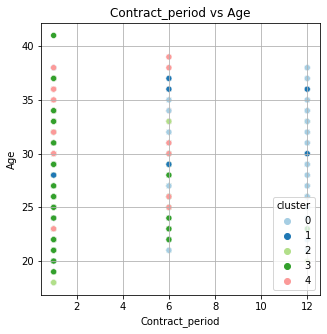

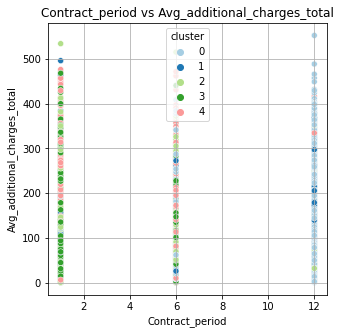

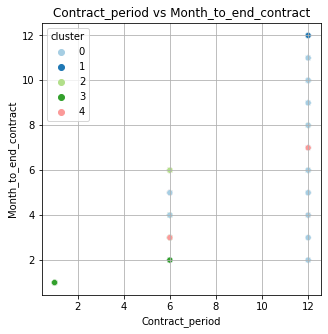

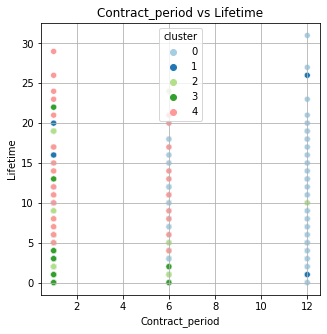

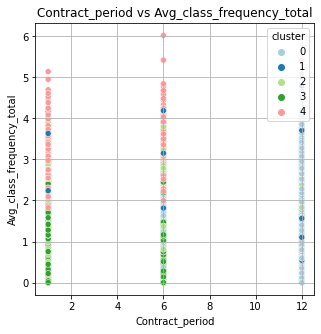

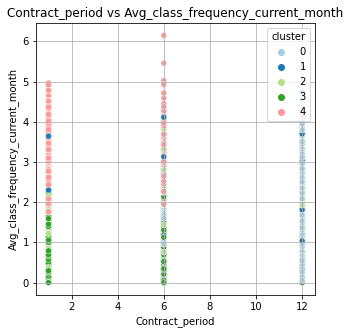

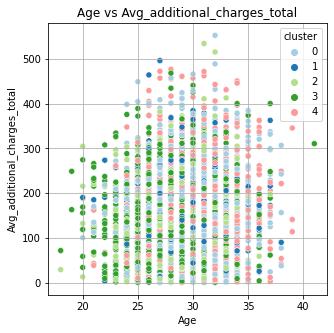

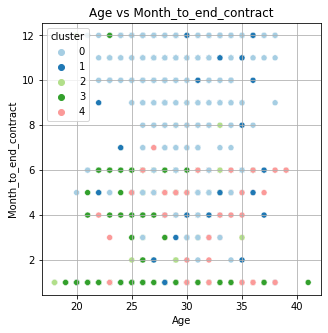

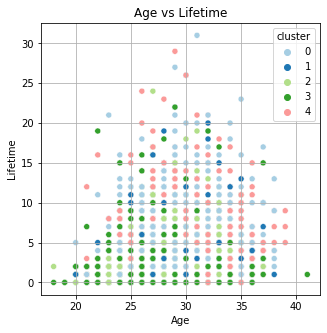

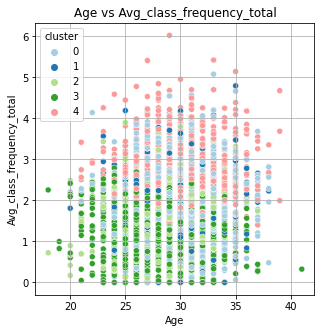

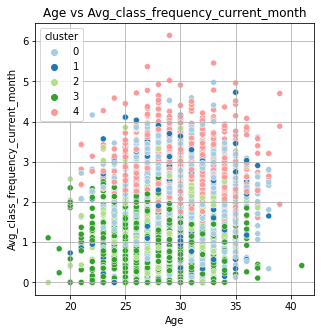

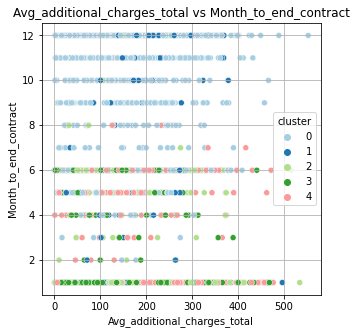

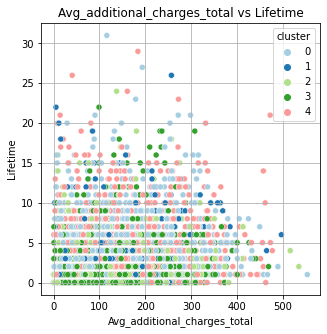

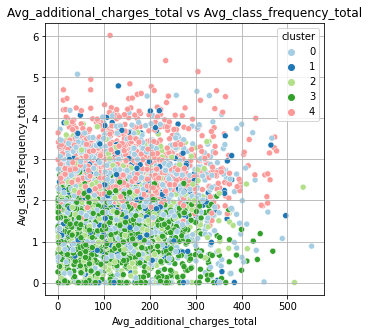

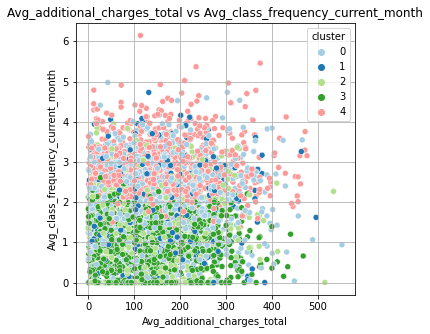

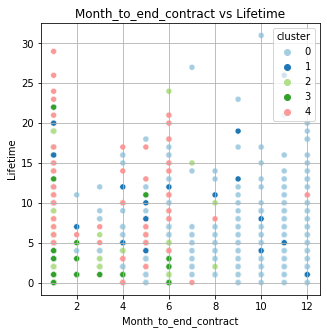

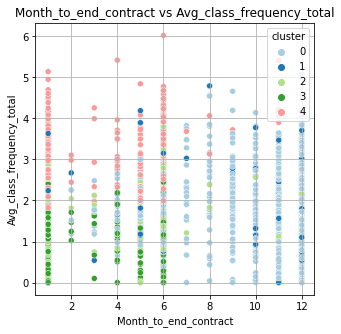

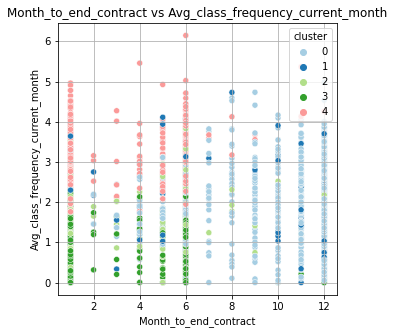

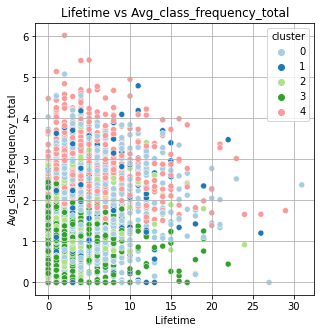

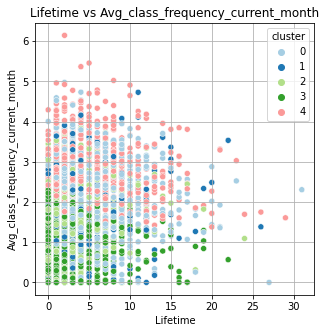

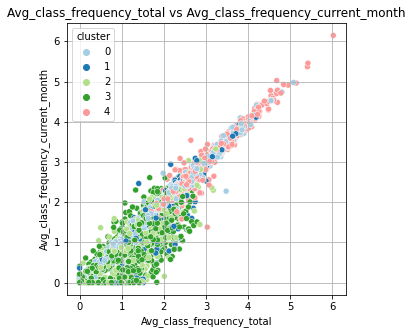

In [42]:
# отрисуем графики для попарных сочетаний небулевых признаков с разметкой по кластерам
col_cluster = list(itertools.combinations(df_clear_non_boolean.drop('cluster', axis=1).columns, 2))

for pair in col_cluster:
    show_clusters_on_plot_non_boolean(df_clear, pair[0], pair[1], 'cluster')
    

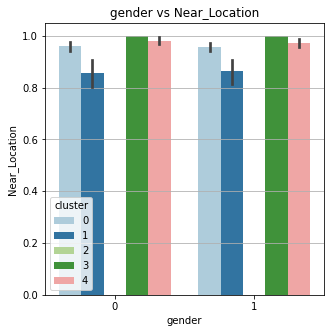

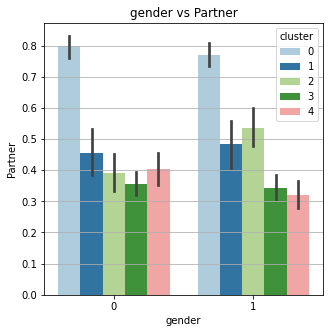

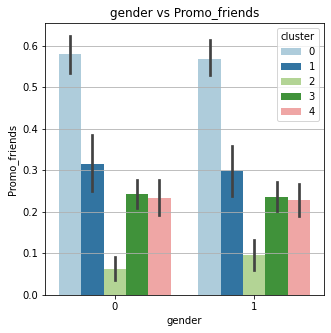

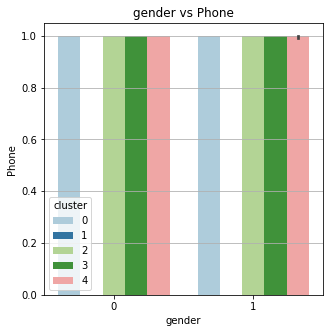

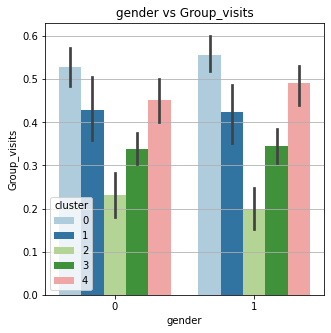

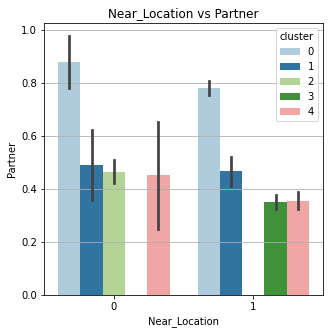

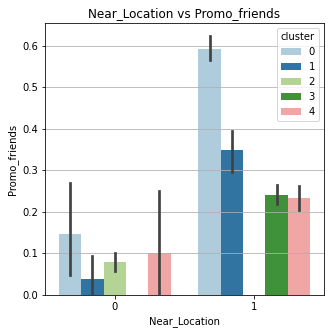

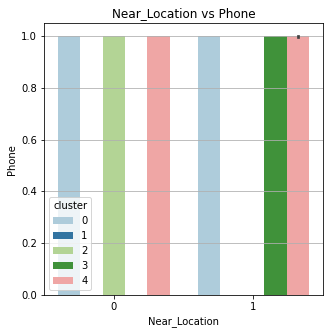

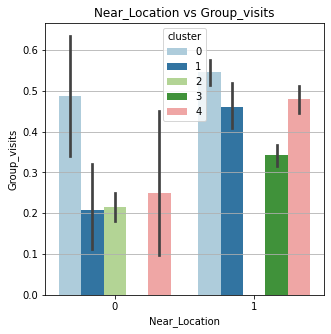

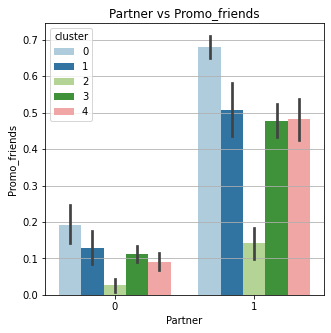

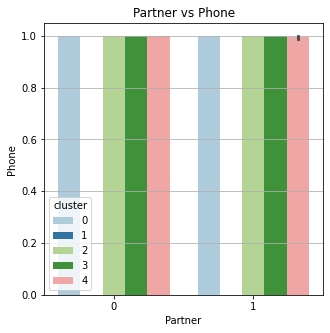

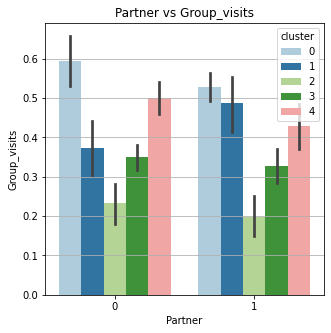

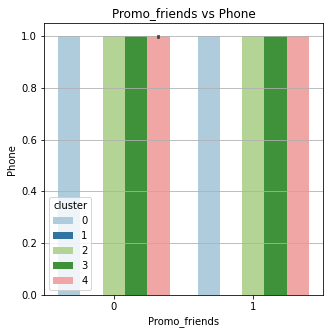

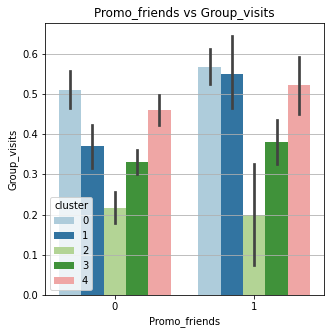

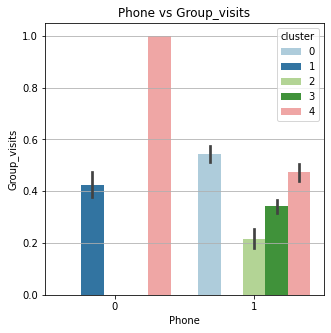

In [45]:
# отрисуем графики для попарных сочетаний булевых признаков с разметкой по кластерам
col_cluster = list(itertools.combinations(df_clear_boolean.drop('cluster', axis=1).columns, 2))

for pair in col_cluster:
    show_clusters_on_plot_boolean(df_clear, pair[0], pair[1], 'cluster')
    

In [46]:
df_clear.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
Near_Location,0.959406,0.862338,0.000000,1.000000,0.976134
Partner,0.783168,0.470130,0.463366,0.350238,0.356802
Promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
Phone,1.000000,0.000000,1.000000,1.000000,0.998807
Contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
Group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
Age,29.982178,29.301299,28.477228,28.167987,30.125298
Avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
Month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


In [47]:
df_clear.groupby('cluster').median().T

cluster,0,1,2,3,4
gender,1.000000,1.000000,0.000000,0.000000,1.000000
Near_Location,1.000000,1.000000,0.000000,1.000000,1.000000
Partner,1.000000,0.000000,0.000000,0.000000,0.000000
Promo_friends,1.000000,0.000000,0.000000,0.000000,0.000000
Phone,1.000000,0.000000,1.000000,1.000000,1.000000
Contract_period,12.000000,1.000000,1.000000,1.000000,1.000000
Group_visits,1.000000,0.000000,0.000000,0.000000,0.000000
Age,30.000000,29.000000,29.000000,28.000000,30.000000
Avg_additional_charges_total,156.459615,136.917294,124.999854,119.232493,149.615442
Month_to_end_contract,11.000000,1.000000,1.000000,1.000000,1.000000


Поскольку ранее мы уже выделяли параметры длительности абонемента, возраста, оставшихся оплаченных месяцев и кол-вом посещений в предыдущем месяце, видно что наиболее склонные к оттоку будут посетители из 3 кластера:
- наименьший период оплаченного абонемента (1,9 месяца)
- наименьший возраст (28 лет)
- наименьшие траты в среднем на доп.услуги (131,6 тыс денег)
- наименьшее кол-во оставшихся оплаченных месяцев (1,8 месяца)
- наименьшая длительность непрерывного посещения зала (2,4 месяца в среднем)
- наименьшее среднее кол-во посещений зала в текущем месяце (1,2 раза)
- наименьшее среднее кол-во посещений зала в предыдущем месяце (1,03 раза)

In [24]:
df.groupby('cluster').agg({'Churn':'mean'})

,Churn
cluster,
0,0.027723
1,0.267532
2,0.443564
3,0.514263
4,0.068019


Наиболее склонны к оттоку посетители 3 кластера.

## Сформулируем выводы и базовые рекомендации

### прогноз вероятности оттока для каждого клиента на следующий месяц

На основании всего вышеизложенного, мы можем сказать, что наиболее склонные к оттоку посетители четвёртого по счёту кластера: молодые, мало тратящие на доп.опции, редко ходящие в фитнес-центр и купившие минимальный абонемент на 1 месяц.

### типичные портреты клиентов

Все посетители фитнес-центра можно разделить на 5 групп:
- **1-й кластер**: Живёт преимущественно рядом (95,9%), является сотрудником компании-партнёра (78,3%), пришёл с промокодом от друзей (57,4%), оставляет телефон всегда (100%), как правило, берёт годовой абонемент, посещает групповые занятия (54,2%), преимущественно более старшего возраста (средний возраст 29,9 лет, медианный - 30 лет), тратит много на доп.опции (160,7 тыс денег в среднем, медиана - 156,4 тыс денег), имеет длительную историю посещения фитнес-центра (4,7 месяцев в среднем), посещает зал в среднем 2 раза в неделю и в этом, и в предыдущем месяце.


- **2-й кластер**: Живёт преимущественно рядом (86,2%), почти в половине случаев является сотрудником компании-партнёра (47%),  редко приходит с промокодом от друзей (30,6%), не оставляет контактный телефон вообще, берёт абонемент на 4,7 месяца в среднем (медиана - 1 месяц), посещает групповые занятия (42%), преимущественно среднего возраста (средний возраст 29,3 лет, медианный - 29 лет), тратит средне на доп.опции (143,9 тыс денег в среднем, медиана - 136,9 тыс денег), имеет среднюю историю посещения фитнес-центра (3,9 месяцев в среднем), посещает зал в среднем 1,8 раза в неделю и в этом, и 1,7 раз в предыдущем месяце.


- **3-й кластер**: Живёт всегда далеко, почти в половине случаев является сотрудником компании-партнёра (46,3%), очень редко приходит с промокодом от друзей (7,9%), всегда оставляет контактный телефон (100%), берёт абонемент на 2,3 месяца в среднем (медиана - 1 месяц), посещает групповые занятия (21%), преимущественно молодого возраста (средний возраст 28,4 лет, медианный - 29 лет), тратит мало на доп.опции (135,4 тыс денег в среднем, медиана - 124,9 тыс денег), имеет короткую историю посещения фитнес-центра (2,8 месяцев в среднем), посещает зал в среднем 1,6 раза в неделю и в этом, и 1,4 раза в предыдущем месяце.


- **4-й кластер**: Живёт всегда рядом, примерно в трети случаев является сотрудником компании-партнёра (35%), редко приходит с промокодом от друзей (24%), всегда оставляет контактный телефон (100%), берёт абонемент на 1,9 месяца в среднем (медиана - 1 месяц), посещает групповые занятия (34%), преимущественно молодого возраста (средний возраст 28,1 лет, медианный - 28 лет), тратит мало на доп.опции (131,6 тыс денег в среднем, медиана - 119,2 тыс денег), имеет короткую историю посещения фитнес-центра (2,4 месяцев в среднем), посещает зал в среднем 1,2 раза в неделю и в этом, и 1 раз в предыдущем месяце.


- **5-й кластер**: Живёт преимущественно рядом (97,6%), примерно в трети случаев является сотрудником компании-партнёра (35,6%), редко приходит с промокодом от друзей (23%), почти всегда оставляет контактный телефон (99,8%), берёт абонемент на 2,6 месяца в среднем (медиана - 1 месяц), посещает групповые занятия (47%), преимущественно более старшего возраста (средний возраст 30,1 лет, медианный - 30 лет), тратит много на доп.опции (161,6 тыс денег в среднем, медиана - 149,6 тыс денег), имеет длинную историю посещения фитнес-центра (4,8 месяцев в среднем), посещает зал в среднем 2,8 раза в неделю и в этом, и 2,7 раз в предыдущем месяце.

### основные признаки, наиболее сильно влияющие на отток

- длительность непрерывного посещения зала 
- среднее кол-во посещений зала в предыдущем месяце 
- среднее кол-во посещений зала в текущем месяце 
- возраст 
- траты в среднем на доп.услуги 
- период оплаченного абонемента
- кол-во оставшихся оплаченных месяцев 

### основные выводы и рекомендации по повышению качества работы с клиентами:
1. целевые группы клиентов;
2. меры по снижению оттока;
3. другие особенности взаимодействия с клиентами.

Целевые группы клиентов для фитнес-зала - это посетители, относящиеся к первому и пятому кластерам: они больше тратят и регулярнее всех ходят. При изменении ценовой политики или рассчёте новой опции нужно ориентироваться в первую очередь на них: это будут наиболее лояльные посетители.

Клиенты, входящие во второй и третий кластер - возможные "точки роста". Для рекомендаций по этим группам посетителей необходимо собрать дополнительную информацию (например, режимы работы общественного транспорта и окружающей инфраструктуры, время посещения зала и других объектов фитнес-центра, и т.п.): есть вероятность что незначительные изменения режима работы фитнес-центра (подстройка под общественный транспорт) или графика работы сотрудников (увеличение кол-ва индивидуальных тренеров или групповых занятий в актуальное для данной целевой аудитории время) смогут ощутимо увеличить удержание посетителей из данных кластеров.

Я бы выделила параметр "суммарная выручка от других услуг фитнес-центра" как интегральный: чем больше посетитель оставляет в сопутствующих спорт-залу услугах (кафе, спорттовары, косметический и массажный салон), тем дольше и надёжнее он ходит - значит, ему нравится фитнес-центр в целом, он подстроил свой распорядок жизни так, чтобы иметь удовольствие посещать именно это место.